In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('bankchurners.csv')

In [3]:
# retirando as duas ultimas colunas como sugerido pelo autor do dataset
df = df.iloc[:, :-2]

In [4]:
# retirando coluna de clientnum
df = df.iloc[:, 1:]

In [5]:
df.columns = ['attrition_flag', 'age', 'gender', 'dependent_count', 'education_level', 'marital_status', 'income_category',
              'card_category', 'months_book', 'total_relationship_count', 'months_inactive_12_mon',
              'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal', 'avg_open_to_buy', 'total_amt_change_Q4_Q1',
              'total_trans_amt', 'total_trans_ct', 'total_ct_change_Q4_Q1', 'avg_utilization_ratio']

In [6]:
df.head(4)

,attrition_flag,age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_book,total_relationship_count,months_inactive_12_mon,contacts_count_12_mon,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_change_Q4_Q1,total_trans_amt,total_trans_ct,total_ct_change_Q4_Q1,avg_utilization_ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760


In [7]:
df = df[df['education_level'] != 'Unknown']
df = df[df['marital_status'] != 'Unknown']
df = df[df['income_category'] != 'Unknown']

In [8]:
print('O tamanho do dataset passa a ser de: ' + str(len(df)))

O tamanho do dataset passa a ser de: 7081


### Transformação de Variáveis

#### Faremos Label Encoding

In [9]:
colunas = ['gender', 'education_level', 'income_category']
la_gender = preprocessing.LabelEncoder().fit(df['gender'])
la_education = preprocessing.LabelEncoder().fit(df['education_level'])
la_income = preprocessing.LabelEncoder().fit(df['income_category'])

In [10]:
df['gender'] = la_gender.transform(df['gender'])
df['education_level'] = la_education.transform(df['education_level'])
df['income_category'] = la_income.transform(df['income_category'])

In [11]:
colunas = ['gender', 'education_level', 'income_category']
for col in colunas:
    df[col] = df[col].astype('category')

In [12]:
# Existing Customer == 0; Atrited Customer == 1
df['attrition_flag'] = np.where(df['attrition_flag'] == 'Existing Customer', 0, 1)

In [13]:
df = df.drop(columns = ['marital_status', 'card_category'], axis = 1)

In [14]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 8)

In [16]:
print('Tamanho do dataset de treino: ' + str(len(X_train)))
print('Tamanho do dataset de teste: ' + str(len(X_test)))

Tamanho do dataset de treino: 4956
Tamanho do dataset de teste: 2125


In [17]:
# moonths book
colunas_norm = ['age', 'credit_limit', 'total_revolving_bal', 'avg_open_to_buy',
                'total_amt_change_Q4_Q1', 'total_trans_amt', 'total_trans_ct', 'total_ct_change_Q4_Q1',
                'avg_utilization_ratio']

In [18]:
scaler = preprocessing.RobustScaler().fit(X_train[colunas_norm])

In [19]:
X_train[colunas_norm] = scaler.transform(X_train[colunas_norm])
X_test[colunas_norm] = scaler.transform(X_test[colunas_norm])

In [20]:
oversampled = SMOTENC(categorical_features = [1, 3, 4], random_state = 8)
X_train, y_train = oversampled.fit_resample(X_train, y_train)

### Machine Learning

#### Funçoes com Metricas

In [21]:
def metricas_avaliacao(x, y, previsao, modelo, versao):
    # mudei o y_test do acuracia pra y
    acuracia = round(accuracy_score(y, previsao), 4)
    roc_auc = metrics.roc_auc_score(y, previsao)
    print('Esse é o ' + versao + ' do projeto!')
    print('-' * 58)
    print('A acurácia do modelo de ' + modelo + ' é: ' + str(round(acuracia, 4)))
    print('O valor ROC-AUC do modelo de ' + modelo + ' é: ' + str(round(roc_auc, 4)))
    print('-' * 58)
    mat_confusao = metrics.confusion_matrix(y, previsao)
    mat_confusao = pd.DataFrame(mat_confusao)
    print(mat_confusao)
    print('-' * 58)
    nome_target = ['Cliente Ativo', 'Cliente Inativo']
    print(classification_report(y, previsao, target_names = nome_target))
    

In [22]:
def roc_auc_curva(y, previsao, modelo):
    fpr, tpr, thresholds = metrics.roc_curve(y, previsao)
    roc_auc = metrics.roc_auc_score(y, previsao)
    plt.title('ROC Curve do modelo: ' + modelo + '!')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [23]:
dicionario_resultados = []
def resultados_modelos(test_y, previsao, nome_modelo):
    acuracia_res = round(accuracy_score(test_y, previsao), 4)
    roc_auc_res = round(metrics.roc_auc_score(test_y, previsao), 4)
    dicionario_res = {'modelo' : nome_modelo, 'acuracia' : acuracia_res, 'roc_auc' : roc_auc_res}
    dicionario_resultados.append(dicionario_res)
    global df_resultados
    df_resultados = pd.DataFrame(dicionario_resultados)
    return df_resultados

#### Modelo Escolhido

In [24]:
selecao_variaveis = RandomForestClassifier(criterion = 'entropy',
                                           n_estimators = 1500,
                                           max_depth = 21,
                                           random_state = 8, n_jobs = 12).fit(X_train, y_train)

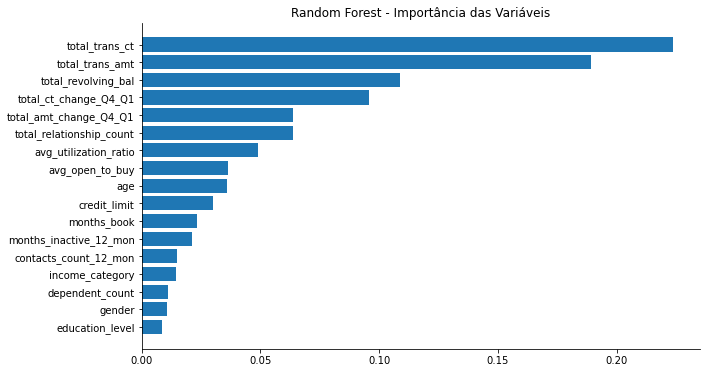

In [25]:
fig, ax = plt.subplots(figsize = (10, 6))
rearrumando = selecao_variaveis.feature_importances_.argsort()
plt.barh(selecao_variaveis.feature_names_in_[rearrumando], selecao_variaveis.feature_importances_[rearrumando])
plt.title('Random Forest - Importância das Variáveis')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show();

In [26]:
colunas_selecionadas = ['total_trans_ct', 'total_trans_amt', 'total_revolving_bal', 'total_ct_change_Q4_Q1',
                        'total_amt_change_Q4_Q1', 'avg_utilization_ratio', 'total_relationship_count',
                        'avg_open_to_buy', 'age', 'credit_limit', 'gender', 'dependent_count', 'education_level',
                        'income_category']

In [27]:
X_train_selecao = X_train[colunas_selecionadas]
X_test_selecao = X_test[colunas_selecionadas]

#### Com GridSeachCV

In [28]:
def grid_scores(x, versao):
    print(f'Resultados do melhor modelo obtido com GridSearchCV para o modelo:', versao)
    print('-' * 80)
    print('Os melhores hiperparâmetros obtidos foram:')
    print(x.best_params_)
    print('-' * 80)
    print('Resultados da métrica de Acurácia:\n')
    acc_media = round(x.cv_results_['mean_test_accuracy'][x.best_index_], 4)
    print(f'Média da Accuracy é:', acc_media)
    acc_std = round(x.cv_results_['std_test_accuracy'][x.best_index_], 4)
    print(f'Desvio-padrão da Accuracy é:', acc_std)
    print('-' * 80)
    print('Resultados da métrica de ROC-AUC:\n')
    roc_auc_media = round(x.cv_results_['mean_test_roc_auc'][x.best_index_], 4)
    print(f'Média do ROC-AUC é:', roc_auc_media)
    roc_auc_std = round(x.cv_results_['std_test_roc_auc'][x.best_index_], 4)
    print(f'Desvio-padrão do ROC-AUC é:', roc_auc_std)
    
    

In [29]:
criterio = ['gini', 'entropy']
estimacoes = [50, 100, 500, 1000, 1500]
max_dep = [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

In [30]:
%%time
busca_modelo = GridSearchCV(estimator = RandomForestClassifier(random_state = 8),
                             param_grid = {'n_estimators' : estimacoes, 'criterion' : criterio, 'max_depth' : max_dep},
                             n_jobs = -1, cv = 5, refit = 'roc_auc', 
                             scoring = ['accuracy', 'roc_auc']).fit(X_train_selecao, y_train)

Wall time: 5min 36s


In [31]:
grid_scores(busca_modelo, 'Random Forest com Seleção de Variáveis')

Resultados do melhor modelo obtido com GridSearchCV para o modelo: Random Forest com Seleção de Variáveis
--------------------------------------------------------------------------------
Os melhores hiperparâmetros obtidos foram:
{'criterion': 'entropy', 'max_depth': 17, 'n_estimators': 500}
--------------------------------------------------------------------------------
Resultados da métrica de Acurácia:

Média da Accuracy é: 0.9664
Desvio-padrão da Accuracy é: 0.0037
--------------------------------------------------------------------------------
Resultados da métrica de ROC-AUC:

Média do ROC-AUC é: 0.9946
Desvio-padrão do ROC-AUC é: 0.0014


#### Modelo Escolhido

In [28]:
modelo = RandomForestClassifier(criterion = 'entropy',
                                   n_estimators = 500,
                                   max_depth = 17,
                                   random_state = 8, n_jobs = 12).fit(X_train_selecao, y_train)
previsao = modelo.predict(X_test_selecao)

In [29]:
metricas_avaliacao(X_test_selecao, y_test, previsao, 'Random Forest - Com Seleção de Variáveis', 'sexto modelo')

Esse é o sexto modelo do projeto!
----------------------------------------------------------
A acurácia do modelo de Random Forest - Com Seleção de Variáveis é: 0.9572
O valor ROC-AUC do modelo de Random Forest - Com Seleção de Variáveis é: 0.9339
----------------------------------------------------------
      0    1
0  1744   59
1    32  290
----------------------------------------------------------
                 precision    recall  f1-score   support

  Cliente Ativo       0.98      0.97      0.97      1803
Cliente Inativo       0.83      0.90      0.86       322

       accuracy                           0.96      2125
      macro avg       0.91      0.93      0.92      2125
   weighted avg       0.96      0.96      0.96      2125



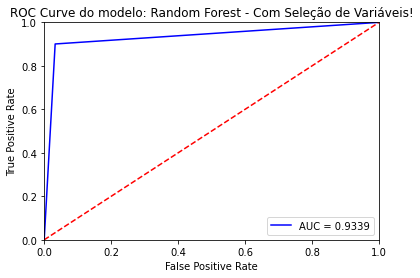

In [30]:
roc_auc_curva(y_test, previsao, 'Random Forest - Com Seleção de Variáveis')

In [31]:
resultados_modelos(y_test, previsao, 'XGRandom Forest - Com Seleção de Variáveis')

,modelo,acuracia,roc_auc
0,XGRandom Forest - Com Seleção de Variáveis,0.9572,0.9339


#### Salvando o modelo

In [32]:
colunas_selecionadas = ['total_trans_ct', 'total_trans_amt', 'total_revolving_bal', 'total_ct_change_Q4_Q1',
                        'total_amt_change_Q4_Q1', 'avg_utilization_ratio', 'total_relationship_count',
                        'avg_open_to_buy', 'age', 'credit_limit', 'gender', 'dependent_count', 'education_level',
                        'income_category']

for col in colunas_selecionadas:
    if(df[col].dtype != 'category'):
        print(f'Valor máximo: {np.max(df[col])} e valor mínimo: {np.min(df[col])} da variável {col}')
    else:
        print({col : df[col].cat.categories})

Valor máximo: 134 e valor mínimo: 10 da variável total_trans_ct
Valor máximo: 17995 e valor mínimo: 510 da variável total_trans_amt
Valor máximo: 2517 e valor mínimo: 0 da variável total_revolving_bal
Valor máximo: 3.714 e valor mínimo: 0.0 da variável total_ct_change_Q4_Q1
Valor máximo: 3.397 e valor mínimo: 0.0 da variável total_amt_change_Q4_Q1
Valor máximo: 0.999 e valor mínimo: 0.0 da variável avg_utilization_ratio
Valor máximo: 6 e valor mínimo: 1 da variável total_relationship_count
Valor máximo: 34516.0 e valor mínimo: 3.0 da variável avg_open_to_buy
Valor máximo: 73 e valor mínimo: 26 da variável age
Valor máximo: 34516.0 e valor mínimo: 1438.3 da variável credit_limit
{'gender': Int64Index([0, 1], dtype='int64')}
Valor máximo: 5 e valor mínimo: 0 da variável dependent_count
{'education_level': Int64Index([0, 1, 2, 3, 4, 5], dtype='int64')}
{'income_category': Int64Index([0, 1, 2, 3, 4], dtype='int64')}


In [33]:
X_train_selecao.head(4)

,total_trans_ct,total_trans_amt,total_revolving_bal,total_ct_change_Q4_Q1,total_amt_change_Q4_Q1,avg_utilization_ratio,total_relationship_count,avg_open_to_buy,age,credit_limit,gender,dependent_count,education_level,income_category
0,-0.783784,-1.053837,0.056507,0.858369,0.017621,0.195219,6,0.026600,0.090909,0.068970,1,4,3,1
1,-0.945946,-0.849465,-0.876370,-1.051502,-1.480176,-0.372510,3,-0.211209,-0.727273,-0.335979,1,3,0,3
2,-0.972973,-0.874444,-0.006507,1.021459,0.859031,0.161355,5,0.032831,0.000000,0.064130,0,2,2,4
3,-0.837838,-0.400606,-0.876370,-0.858369,0.000000,-0.372510,6,-0.168948,-0.181818,-0.293303,0,2,2,4


In [34]:
lista = X_train_selecao.columns.to_list()

In [35]:
lista

['total_trans_ct',
 'total_trans_amt',
 'total_revolving_bal',
 'total_ct_change_Q4_Q1',
 'total_amt_change_Q4_Q1',
 'avg_utilization_ratio',
 'total_relationship_count',
 'avg_open_to_buy',
 'age',
 'credit_limit',
 'gender',
 'dependent_count',
 'education_level',
 'income_category']

In [75]:
%%time
resultados_ativo = 0
resultados_inativo = 0
# o range tem q lembrar que é exclusivo. entao coloca um a mais
for i in range(1):
    vetor_sem_transformar = [np.random.uniform(10, 134), np.random.uniform(510, 17995), np.random.uniform(0, 2517),
                np.random.uniform(0, 3.71), np.random.uniform(0, 3.39), np.random.uniform(0, 0.99),
                np.random.randint(1, 7), np.random.uniform(3, 34516), np.random.randint(26, 73),
                np.random.uniform(1439, 34516), np.random.randint(0, 2), np.random.randint(0, 6),
                np.random.randint(0, 6), np.random.randint(0, 5)]

    vetor = np.array(vetor_sem_transformar)
    vetor = vetor.reshape(1, -1)
    d = pd.DataFrame(vetor, columns = [X_train_selecao.columns])

    colunas_norm = ['age', 'credit_limit', 'total_revolving_bal', 'avg_open_to_buy',
                        'total_amt_change_Q4_Q1', 'total_trans_amt', 'total_trans_ct', 'total_ct_change_Q4_Q1',
                        'avg_utilization_ratio']

    d[colunas_norm] = scaler.transform(d[colunas_norm])

    vetor = np.array(d)
    vetor = vetor.reshape(1, -1)
    #modelo.predict(vetor)
    modelo.predict_proba(vetor)
    classe = modelo.predict(vetor)
    proba = modelo.predict_proba(vetor)

    #if (classe == 0):
        #resultados_ativo += 1
    #elif(classe == 1):
        #resultados_inativo += 1
    #else:
        #pass

Wall time: 179 ms


In [76]:
#print(resultados_ativo)
#print(resultados_inativo)

In [78]:
print(classe)
print(proba[0])

[1]
[0.306 0.694]


#### Salvando Modelo

In [43]:
import pickle

In [44]:
#with open('modelo_treinado.pkl', 'wb') as f:
    #pickle.dump(modelo, f)

In [45]:
#with open('scaler_treinado.pkl', 'wb') as f:
    #pickle.dump(scaler, f)